# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project I will try to find out the best place for a __pub__ in __Yekaterinburg, Russia__. The stakeholders that will be able to benefit from this knowledge are those who are interested in opening such a venue.

There are a lot of criteria which can define whether a place is good or not. We are interested in locations with following characteristics:
- low amount of pubs nearby
- low amount of food venues nearby
- a lot of people traffic in the area. It mainly depends on having universities, work centers and such in the vicinity

Using the data science metodology we will find out the neighborhoods of the city, filter out the best of them and present this information to help the stakeholders in making the decision.

## Data <a name="data"></a>

The aforecited problem requires the following data:
- __food venues locations__
- __locations of universities and work centers__  

Defining neighborhood is also a task we need to do. Yekaterinburg does not have such a concept and the 'city district' used there is too huge in terms of area covered. In order to deal with it we will split the city using the ZIP codes available publicly.

The data sources we will use are the following:
- __Foursquare API__ for any venue information we will need
- __<a href="https://geocode.xyz/">Geocode</a>__ for ZIP codes and their locations

## Data Gathering and Preparation <a name="dgp"></a>

### Collecting ZIP information

To create neighborhoods we need the __ZIP postal code, logitude and latitude__. It is worth mentioning that some of the codes that refer to the __Yekaterinburg__ city are actually much farther away and will be dropped later based on the map location.  
First comes scraping this info from the website with the codes.

In [44]:
import requests as rq
import pandas as pd
import json

In [45]:
# API key for the service. Deleted for privacy
geo_api_key = ''

In [78]:
link = 'https://geocode.xyz/екатеринбург?json=1&auth={}'.format(geo_api_key)
resp = rq.get(link)
parsed = json.loads(resp.text)

zip_codes = []
for item in parsed['alt']['loc']:
    zip_codes.append([item['postal'], item['latt'], item['longt']])

In [79]:
df = pd.DataFrame(zip_codes) # Will not rewrite this just in case
df.rename({0: 'Postal Code', 1: 'Latitude', 2: 'Longitude'}, axis=1, inplace=True)
# The amount of request we can do to API is limited
# To avoid overloading the next time we can use the saved copy
df.to_csv('zip_cleaned.csv', index=False)

In [106]:
# Loading the info
df_locs = pd.read_csv('zip_cleaned.csv')
# Also let's make postal codes our index for convenience
df_locs.set_index('Postal Code', inplace=True)
df_locs.head(5)

,Latitude,Longitude
Postal Code,,
620000,56.79817,60.61521
620007,56.79593,60.76726
620010,56.75276,60.70887
620012,56.89393,60.60044
620014,56.84037,60.58504


Let's check the resulting locations on the map. We will need to decide which codes we need to drop now.

In [107]:
# First find the location of the city itself
from geopy.geocoders import Nominatim
address = 'Yekaterinburg, Russia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Yekaterinburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Yekaterinburg are 56.839104, 60.60825.


In [217]:
# Now draw the map
import folium

# create map
city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lbl, lat, lon in zip(df_locs.index, df_locs['Latitude'], df_locs['Longitude']):
    label = folium.Popup(str(lbl))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        fill=True,
        popup=label).add_to(city_map)
city_map

OK, this is looking quite qood. As I mentioned we need to drop some of the codes that are considered to be related to the city but actually are much farther away from it than we need, There is one to the bottom right, a few in the bottom left, one in the top.

In [109]:
# Drop the unnecessary rows
df_locs.drop([620093, 620912, 620060, 620007, 620103, 624090], axis=0, inplace=True)

Let's look at the map again

In [110]:
# create map
city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lbl, lat, lon in zip(df_locs.index, df_locs['Latitude'], df_locs['Longitude']):
    label = folium.Popup(str(lbl))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        fill=True,
        popup=label).add_to(city_map)
city_map

### Foursquare info

Now that we have the location data we need to take venues into consideration. As we stated before the three thing we need to know about is the amount of fastfoods, pubs and places with a lot of people nearby.

First of all, we need to decide what range is nearby. The idea I am sticking to is quite simple. As we rely on people coming to our pub it must be accessible by walking no more that 15-20 minutes from any place in the area. Assuming the average speed of a person is 6 km/h it will result in the radius of approximately *__800 meters__*.

#### Fast food places

Now we need to gather information about fast food venues in the vicinity of 800 meters of each location. The restaurants are not our competitors here so we will skip them. Pubs will also be selected as the separate category.

The information we will need is only the amount of such venues nearby. Everything other than that (e.g. location, etc) is unnecessary.

In [111]:
# Foursquare API key. Deleted for privacy
CLIENT_ID = ''
CLIENT_SECRET = ''

VERSION = '20180605'
# Anything more than a hundred is already too much so why bother
LIMIT = 100

In [156]:
def getNearbyVenuesByCategories(latitude, longitude, categories, radius=500):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        ','.join(categories))
    # make the GET request
    results = rq.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list = [(v['venue']['name'], v['venue']['categories'][0]['name']) for v in results]

    return(venues_list)

In [158]:
# Now get all food venues
food_venues = {}
for item in df_locs.index:
    food_venues[item] = getNearbyVenuesByCategories(df_locs.loc[item]['Latitude'],
                                                    df_locs.loc[item]['Longitude'],
                                                    ['4d4b7105d754a06374d81259'],
                                                    800)

In [172]:
# Filter the restaurants out
for item in food_venues.items():
    for venue in item[1]:
        if 'restaurant' in venue[1].lower():
            food_venues[item[0]].remove(venue)

Let's look at an example of info we got.

In [175]:
food_venues[620000]

[('Матильда', 'Bakery'),
 ('Грильяж', 'Café'),
 ('KastaNeDa', 'Steakhouse'),
 ('SUBWAY', 'Sandwich Place'),
 ('KFC', 'Wings Joint'),
 ('Три Ватрушки', 'Café'),
 ('Daddy Local bar & cafe', 'Café'),
 ('Кулинаръ', 'Bakery'),
 ('DODO Пицца', 'Pizza Place'),
 ('«Мечта»', 'Café'),
 ('Европейская пекарня', 'Bakery'),
 ('Burger King', 'Burger Joint'),
 ('Пекарушка', 'Bakery'),
 ('Поль Бейкери', 'Bakery')]

Looking pretty good. Now we need to combine the locations with the amount of food venues nearby.

In [186]:
df_combined = df_locs
df_combined['Food Venue Amount'] = df_combined.index.to_series().apply(lambda x: len(food_venues[x]))
df_combined.head(5)

,Latitude,Longitude,Food Venue Amount,Bar Venue Amount
Postal Code,,,,
620000,56.79817,60.61521,14,2
620010,56.75276,60.70887,5,0
620012,56.89393,60.60044,8,1
620014,56.84037,60.58504,24,4
620016,56.78214,60.54021,7,0


Great. Now make the same actions with pubs (we will take the 'bar' category in foursquare).

In [182]:
bar_venues = {}
for item in df_locs.index:
    bar_venues[item] = getNearbyVenuesByCategories(df_locs.loc[item]['Latitude'],
                                                    df_locs.loc[item]['Longitude'],
                                                    ['4bf58dd8d48988d116941735'],
                                                    800)

In [187]:
# Filter the restaurants (that have bars inside too) out
for item in bar_venues.items():
    for venue in item[1]:
        if 'restaurant' in venue[1].lower():
            bar_venues[item[0]].remove(venue)

In [188]:
bar_venues[620000]

[('Япона Pub', 'Bar')]

In [189]:
df_combined['Bar Venue Amount'] = df_combined.index.to_series().apply(lambda x: len(bar_venues[x]))
df_combined.head(5)

,Latitude,Longitude,Food Venue Amount,Bar Venue Amount
Postal Code,,,,
620000,56.79817,60.61521,14,1
620010,56.75276,60.70887,5,0
620012,56.89393,60.60044,8,1
620014,56.84037,60.58504,24,3
620016,56.78214,60.54021,7,0


#### People traffic

Now one of the most important qualities of the place is the amount of people passing there. This highly depends on the venues nearby. Most of the traffic we need is generated by following categories of places: 
- __entertainment__ - a lot of people on weekends are their
- __universities__ - probably the biggest traffic
- __business centers__ - for the same reasons
- __travelling facilites__ - tourists and travellers tend to spend their time in pubs quite often
The rest if filtered out.

Collecting the data is the same as we did before so let's do it.

In [190]:
people_venues = {}
categories = ['4d4b7104d754a06370d81259', '4d4b7105d754a06372d81259',
              '56aa371be4b08b9a8d573517', '4d4b7105d754a06379d81259']
for item in df_locs.index:
    people_venues[item] = getNearbyVenuesByCategories(df_locs.loc[item]['Latitude'],
                                                    df_locs.loc[item]['Longitude'],
                                                    categories,
                                                    800)

In [193]:
people_venues[620000]

[('Воображариум', 'Theater'),
 ('лотос', 'Dance Studio'),
 ('Будка на Степана Разина', 'Street Art'),
 ('Madlines Workshop', 'Art Gallery'),
 ('MORE TATTOO', 'Art Gallery'),
 ('Царство Боли', 'Art Gallery'),
 ('MADLINES TATTOO COMMUNITY', 'Art Gallery'),
 ('Славкино туссе', 'Country Dance Club')]

In [194]:
df_combined['People Venue Amount'] = df_combined.index.to_series().apply(lambda x: len(people_venues[x]))
df_combined.head(5)

,Latitude,Longitude,Food Venue Amount,Bar Venue Amount,People Venue Amount
Postal Code,,,,,
620000,56.79817,60.61521,14,1,8
620010,56.75276,60.70887,5,0,5
620012,56.89393,60.60044,8,1,2
620014,56.84037,60.58504,24,3,16
620016,56.78214,60.54021,7,0,2


Thus we collected all the necessary data and can move forward to *data analysis*.

## Methodology <a name="methodology"></a>

In this project our main priority is deciding which areas are better for opening the pub depending on the venues nearby and the amount of people traffic.

In the first part we already collected the required data, __outlining the centers of neighborhoods__ and finding __the amount of different types of venues__ in their respected areas with the radius of *800 meters*.

In the second step of our we will try to estimate the worst areas by using heatmaps. We will aim to find out top-3 best places for opening a pub in the city. The ideal place we will be searching for should contain not more than __5__ bars, __10__ food venues. As for the people traffic, the amount of such facilities will be decided depending on what we will see during our analysis.

Finally, we will check the resulting locations on the map and use the data on venues we already received to check whether we can tell more about the top areas.

## Analysis <a name="analysis"></a>

First let's make a heatmap of the data we already have to check whether we can already outline the best and worst areas.

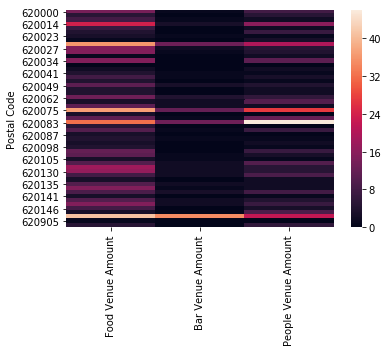

In [199]:
import seaborn as sns

sns.heatmap(df_combined[['Food Venue Amount', 'Bar Venue Amount', 'People Venue Amount']])

There's a bit too much information here. We need to drop some areas. Let's first drop those having more than 5 bars in the vicinity

In [201]:
df_filtered = df_combined
df_filtered = df_filtered[df_filtered['Bar Venue Amount'] <= 5]
df_filtered.shape

(49, 5)

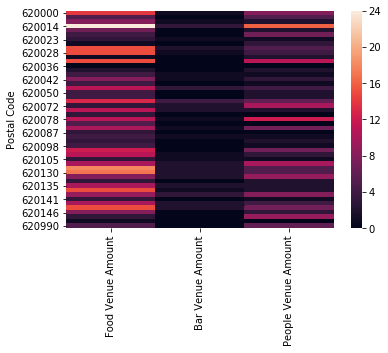

In [202]:
sns.heatmap(df_filtered[['Food Venue Amount', 'Bar Venue Amount', 'People Venue Amount']])

Better, but still not good. Let's also drop those with more than 10 food venues. And those that have less than 5 'people' venues.

In [204]:
df_filtered = df_filtered[df_filtered['Food Venue Amount'] <= 10]
df_filtered = df_filtered[df_filtered['People Venue Amount'] > 5]
df_filtered.shape

(8, 5)

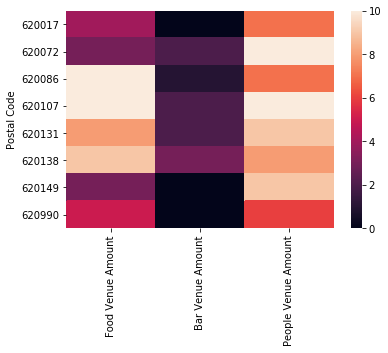

In [205]:
sns.heatmap(df_filtered[['Food Venue Amount', 'Bar Venue Amount', 'People Venue Amount']])

Now that is much better. We have only 8 places to consider and they are indeed looking quite good. The question is: can we make some assumptions based on this.

As we stated before the best area contains (in terms of importance) the least amount of bars around, the most amount of people traffic and the least amount of food venues. The heatmap clearly shows us exactly 3 places to consider: __620017, 620149, 620990__.

The first one have quite a lot of people nearby and not that many food facilities. it can probably be considered the best of them. The second one is a bit better in terms of food facilities but has much less people. The third one is somewhere in between them.

Let's check those on map to see where they are located.

In [215]:
# create map
city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for lbl, lat, lon in zip(df_filtered.index, df_filtered['Latitude'], df_filtered['Longitude']):
    label = folium.Popup(str(lbl))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        fill=True,
        popup=label).add_to(city_map)
city_map

Not that much info can be derived from here, but we still can sea that all those areas are not in the city centre whish is of course to be expected.

Let's explore the top-3 areas a bit more and check what facilities are in them.

In [212]:
ind = 620017
print('--{}--'.format(ind))
print('Food venues:')
for item in food_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))
print('Bar venues:')
for item in bar_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))
print('"People" venues:')
for item in people_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))

--620017--
Food venues:
  Pizza to Pizza (Pizza Place)
  Гефест (Cafeteria)
  Столовая №24 (Cafeteria)
  Mr. Burger (Burger Joint)
Bar venues:
"People" venues:
  Логово Алины (Multiplex)
  Qwesty Djs Crew (Art Gallery)
  Музей Шурави (History Museum)
  Студия звукозаписи УрГПУ (Jazz Club)
  Музей истории УрГПУ (History Museum)
  ксю (Exhibit)
  Ile de France (Art Gallery)


In [213]:
ind = 620149
print('--{}--'.format(ind))
print('Food venues:')
for item in food_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))
print('Bar venues:')
for item in bar_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))
print('"People" venues:')
for item in people_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))

--620149--
Food venues:
  Три Мушкетера (Café)
  Столовая УГМУ (5 корпус) (Cafeteria)
  Кафе "Эркас" (Food)
Bar venues:
"People" venues:
  StoneWash Records (Music Venue)
  StoneWash Records (Music Venue)
  HOLVP STUDIOUS (Concert Hall)
  gym🏋🏿⛹🏿 (Memorial Site)
  Мастеркая-цветоделия (Art Gallery)
  Студия «Gaber» (Music Venue)
  Звукозаписывающая студия (Arts & Entertainment)
  ArtDrive (Dance Studio)
  Art Drive (Dance Studio)


In [214]:
ind = 620990
print('--{}--'.format(ind))
print('Food venues:')
for item in food_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))
print('Bar venues:')
for item in bar_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))
print('"People" venues:')
for item in people_venues[ind]:
    print('  {} ({})'.format(item[0], item[1]))

--620990--
Food venues:
  Штолле (Bakery)
  Pizza Mia (Pizza Place)
  Ле Шале (Food)
  Shaшлыков (BBQ Joint)
  Бай Бабай (Café)
Bar venues:
"People" venues:
  Кинотеатр 7D (Indie Movie Theater)
  KiberRoom (Movie Theater)
  snowboard training base (Roller Rink)
  KartStart (картинг-центр) (Go Kart Track)
  Околофутбола (Movie Theater)
  Киноплекс (Movie Theater)


As we can see all of the three places are quite good. There's no bars nearby, not that many competition with food facilities. Also there are quite a lot of different entertainment places which always provide a stable flow of people.

This concludes our analysis. We have found 3 areas best in terms of the venues in the vicinity with no bars at all. Those areas are not in the city centre but still have a good amount of people traffic.
Although there are still food venues in those locations they are better than the alternatives. The information of what facilites are there exactly can be further used to make necessary decisions.

It is also good to remember that there are other possible candidates (those 8 that we got after filtering) as there may be other factors not included in the data we used (such as land price, transportaion, etc.).

## Results and Discussion <a name="results"></a>

During our analysis we explored the areas of the city Yekaterinburg. Using the postal codes as the basis for outlining the city neighborhoods we analysed the factors that are important in selecting the place for opening a pub. Using the foursquare API we got the data on nearby facilities that were of interest to us. By evaluating the amount of such facilities in the vicinity of the neighborhoods we created a heatmap that allowed us to compare them.

By filtering out some of the data we received we did find the 8 possible areas of interest. All of those areas were shown on map. None of them were in the city centre which was to be expected considering the requirements. Despite of that we did manage to outline the best 3 (and quite possibly even best 1) places. The foursquare data showed that the areas are indeed quite similar to what we were aiming to achieve.

Although we did name one of the areas as __"best"__ it is not necessarily right. This is mainly because of the lack of data we used. As it is a kinda educational project we did ignore some of the important factors. Namely, the cost of land, the transportation nearby, the portrait of an average customer. The location can also depend on the type of the pub and it's aim.

But this information can still be used as a starting point for further analysis. By exploring those 8 areas we defined and adding more valueable info it's quite possible to explore it even on the streets and houses level.

## Conclusion <a name="conclusion"></a>

Purpose of this work was to find out whether it's possible to identify the best locations to open a pub - with big enough people traffic and without much competition with food venues and other pubs/bars. All of it in the Yekaterinburg city which had no neighborhood data to provide.
By using postal codes we were able to overcome the lack of neighborhood data and get the necessary info on nearby venues. By analysing this data we managed to filter out the locations that were not suitable for the task. Analysis of the locations that were left after that showed that they indeed posess all the characteristics we wanted and could be used by stakeholders to make further decisions.

The final decision on the pub location is made considering many factors and the results of this work aim to replace some of them to lessen the stress on stakeholders and help them by providing information in easier to understand way.